In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import (
    ConfusionMatrixDisplay,
    accuracy_score,
    confusion_matrix,
    classification_report,
)
from sklearn.model_selection import StratifiedKFold
from sklearn.svm import SVC

from ucimlrepo import fetch_ucirepo

### Data & Visualisation

16 categorical features given. 101 instances

7 classes

In [2]:
# fetch dataset
zoo = fetch_ucirepo(id=111)

# data (as pandas dataframes)
X = zoo.data.features

In [3]:
expanded_cols = []
X_numeric_pd = X.copy()
for col in X.columns:
    X_numeric_pd[col] = X_numeric_pd[col].astype("category").cat.codes

In [4]:
def custom_combiner(feature, category):
    # print(f"feature: {feature}")
    # print(f"category: {category}")
    if feature == "feature":
        return "test"
    feature_og_name_dict = dict(
        enumerate(X[feature].astype("category").cat.categories)
    )
    return f"{feature}={feature_og_name_dict[category]}"


ohe = OneHotEncoder(drop="if_binary", feature_name_combiner=custom_combiner)
X_oh_np = ohe.fit_transform(X_numeric_pd.to_numpy()).toarray()
feature_names = ohe.get_feature_names_out(
    input_features=X_numeric_pd.columns.to_list()
)

print(X_oh_np.shape)
print(feature_names)


# convert categorical target to numerical
le = LabelEncoder()
y_np = le.fit_transform(zoo.data.targets.to_numpy().flatten() - 1)
print(y_np.shape)
print(np.bincount(y_np))
print(le.classes_.tolist())

(101, 21)
['hair=1' 'feathers=1' 'eggs=1' 'milk=1' 'airborne=1' 'aquatic=1'
 'predator=1' 'toothed=1' 'backbone=1' 'breathes=1' 'venomous=1' 'fins=1'
 'legs=0' 'legs=2' 'legs=4' 'legs=5' 'legs=6' 'legs=8' 'tail=1'
 'domestic=1' 'catsize=1']
(101,)
[41 20  5 13  4  8 10]
[0, 1, 2, 3, 4, 5, 6]


### Common code

In [5]:
# Config
NUM_FOLD = 4
RANDOM_STATE = 73

In [6]:
def get_fold_print_string(fold_result: list[float]):
    mean = np.mean(fold_result)
    ste = np.std(fold_result) / np.sqrt(NUM_FOLD)
    return f"{mean:.3f} ± {ste:.3f}"

In [7]:
def multiclass_classification(
    model,
    model_name: str,
    n_splits: int = NUM_FOLD,
    random_state: int = RANDOM_STATE,
):
    print(f"Model {model_name} with {n_splits}-fold cross-validation\n")
    skf = StratifiedKFold(
        n_splits=n_splits, shuffle=True, random_state=random_state
    )

    fold_accuracy = []

    fig, ax = plt.subplots(1, n_splits, figsize=(15, 4))
    for i, (train_index, test_index) in enumerate(skf.split(X_oh_np, y_np)):
        model.fit(X_oh_np[train_index], y_np[train_index])

        y_pred = model.predict(X_oh_np[test_index])

        acc = accuracy_score(y_np[test_index], y_pred)
        fold_accuracy.append(acc)

        print(classification_report(y_np[test_index], y_pred))

        # Plot confusion matrix
        cm = confusion_matrix(y_np[test_index], y_pred)
        disp = ConfusionMatrixDisplay(
            confusion_matrix=cm, display_labels=model.classes_
        )
        disp.plot(ax=ax[i], xticks_rotation=45)
        ax[i].set_title(f"Fold {i}")

    print("\nCross-Validation Results:")
    print(f"Mean Accuracy: {get_fold_print_string(fold_accuracy)}")

    plt.tight_layout()

## Logistic regression

Model Logistic Regression with 4-fold cross-validation

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        11
           1       1.00      1.00      1.00         5
           2       1.00      0.50      0.67         2
           3       0.75      1.00      0.86         3
           4       1.00      1.00      1.00         1
           5       1.00      1.00      1.00         2
           6       1.00      1.00      1.00         2

    accuracy                           0.96        26
   macro avg       0.96      0.93      0.93        26
weighted avg       0.97      0.96      0.96        26

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        10
           1       1.00      1.00      1.00         5
           2       1.00      1.00      1.00         1
           3       1.00      1.00      1.00         4
           4       1.00      1.00      1.00         1
           5       1.0

/home/kg3217/miniconda3/envs/phd/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/kg3217/miniconda3/envs/phd/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/kg3217/miniconda3/envs/phd/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/kg3217/miniconda3/envs/phd/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/kg3217/miniconda3/envs/phd/lib/python3.10/site-packages/sklearn/

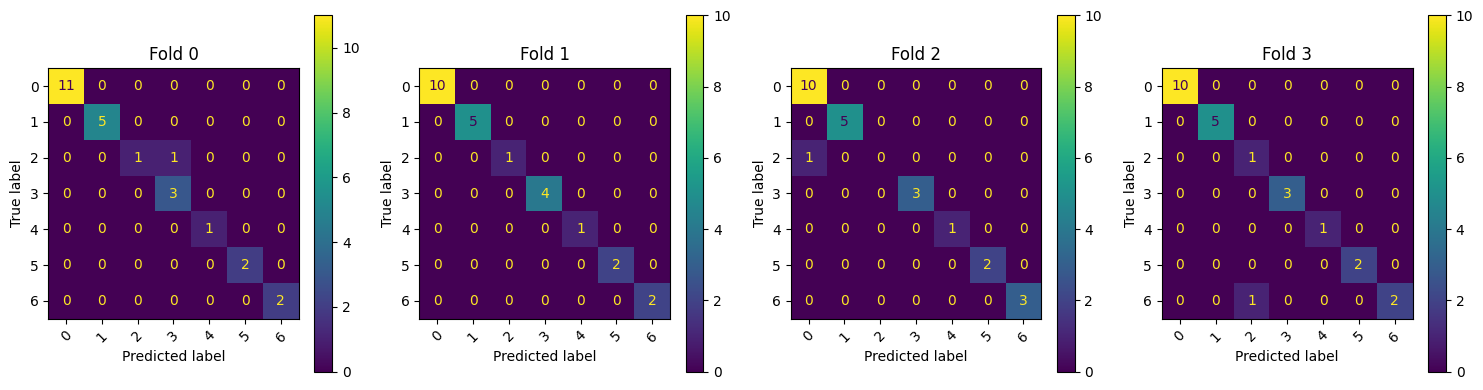

In [8]:
model = LogisticRegression(solver="saga")
multiclass_classification(model, "Logistic Regression")

## Random forest

Model Random Forest with 4-fold cross-validation

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        11
           1       1.00      1.00      1.00         5
           2       1.00      0.50      0.67         2
           3       0.75      1.00      0.86         3
           4       1.00      1.00      1.00         1
           5       1.00      1.00      1.00         2
           6       1.00      1.00      1.00         2

    accuracy                           0.96        26
   macro avg       0.96      0.93      0.93        26
weighted avg       0.97      0.96      0.96        26

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        10
           1       1.00      1.00      1.00         5
           2       1.00      1.00      1.00         1
           3       1.00      1.00      1.00         4
           4       1.00      1.00      1.00         1
           5       1.00     

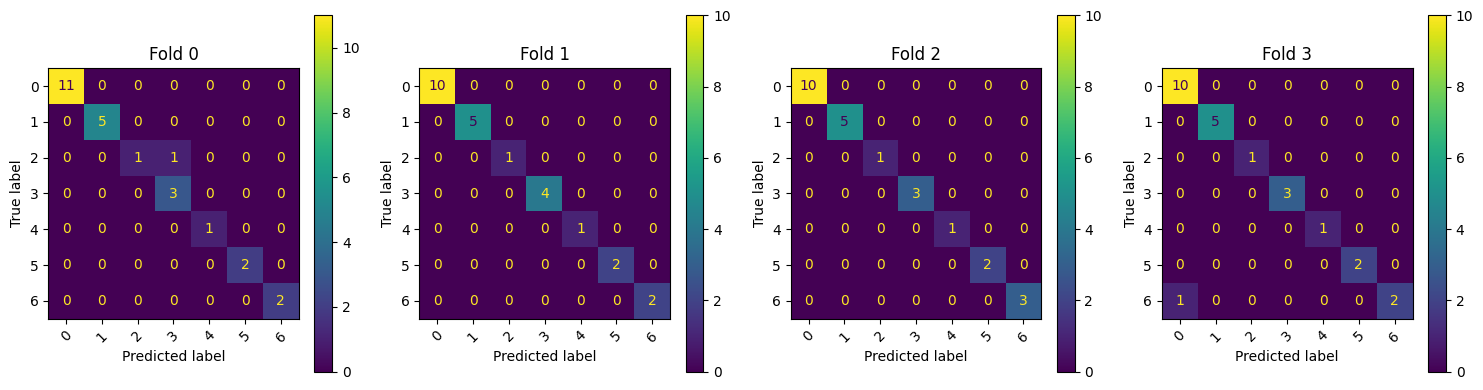

In [9]:
model = RandomForestClassifier(n_estimators=100, random_state=75)
multiclass_classification(model, "Random Forest")

## SVM

Model SVM with 4-fold cross-validation

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        11
           1       1.00      1.00      1.00         5
           2       1.00      0.50      0.67         2
           3       0.75      1.00      0.86         3
           4       1.00      1.00      1.00         1
           5       1.00      1.00      1.00         2
           6       1.00      1.00      1.00         2

    accuracy                           0.96        26
   macro avg       0.96      0.93      0.93        26
weighted avg       0.97      0.96      0.96        26

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        10
           1       1.00      1.00      1.00         5
           2       1.00      1.00      1.00         1
           3       1.00      1.00      1.00         4
           4       1.00      1.00      1.00         1
           5       1.00      1.00     

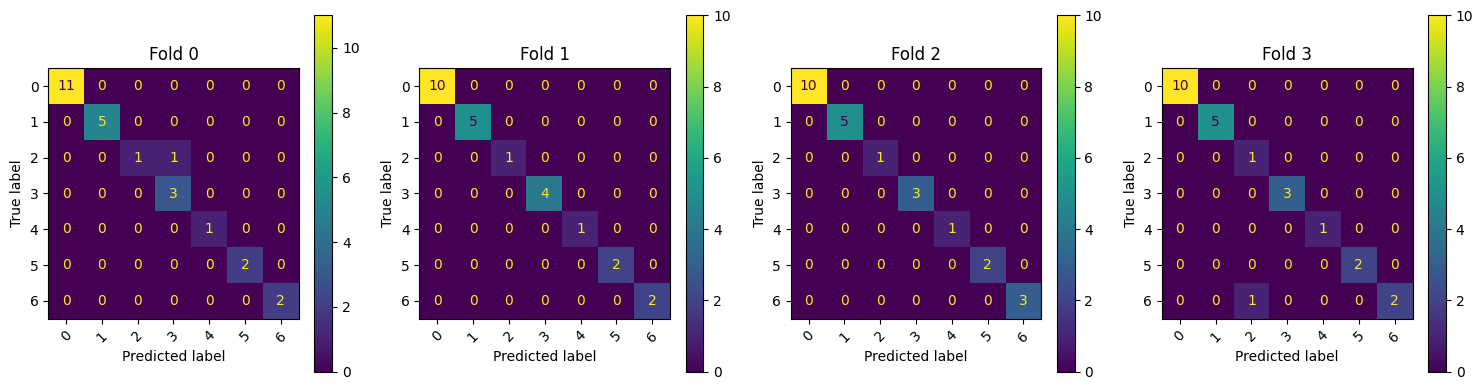

In [10]:
model = SVC(kernel="rbf", random_state=76, class_weight="balanced")
multiclass_classification(model, "SVM")

## Decision tree

In [11]:
# Function to calculate the average depth of the decision tree
def average_tree_depth(tree):
    def _recursive_depth(node, current_depth, depths):
        if (
            tree.children_left[node] == tree.children_right[node]
        ):  # It's a leaf node
            depths.append(current_depth)
            return
        _recursive_depth(tree.children_left[node], current_depth + 1, depths)
        _recursive_depth(tree.children_right[node], current_depth + 1, depths)

    depths = []
    _recursive_depth(0, 0, depths)  # Start from the root node (index 0)
    return sum(depths) / len(depths)


# Function to count the number of branches (internal nodes)
def count_branches(tree):
    n_nodes = tree.node_count  # Total number of nodes in the tree
    n_leaves = tree.n_leaves  # Total number of leaf nodes
    n_branches = n_nodes - n_leaves  # Number of internal nodes (branches)
    return n_branches

Decision tree with 4-fold cross-validation

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        11
           1       1.00      1.00      1.00         5
           2       1.00      0.50      0.67         2
           3       1.00      1.00      1.00         3
           4       1.00      1.00      1.00         1
           5       1.00      1.00      1.00         2
           6       0.67      1.00      0.80         2

    accuracy                           0.96        26
   macro avg       0.95      0.93      0.92        26
weighted avg       0.97      0.96      0.96        26

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        10
           1       1.00      1.00      1.00         5
           2       0.00      0.00      0.00         1
           3       1.00      1.00      1.00         4
           4       0.00      0.00      0.00         1
           5       1.00      1.00 

/home/kg3217/miniconda3/envs/phd/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/kg3217/miniconda3/envs/phd/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/kg3217/miniconda3/envs/phd/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} i

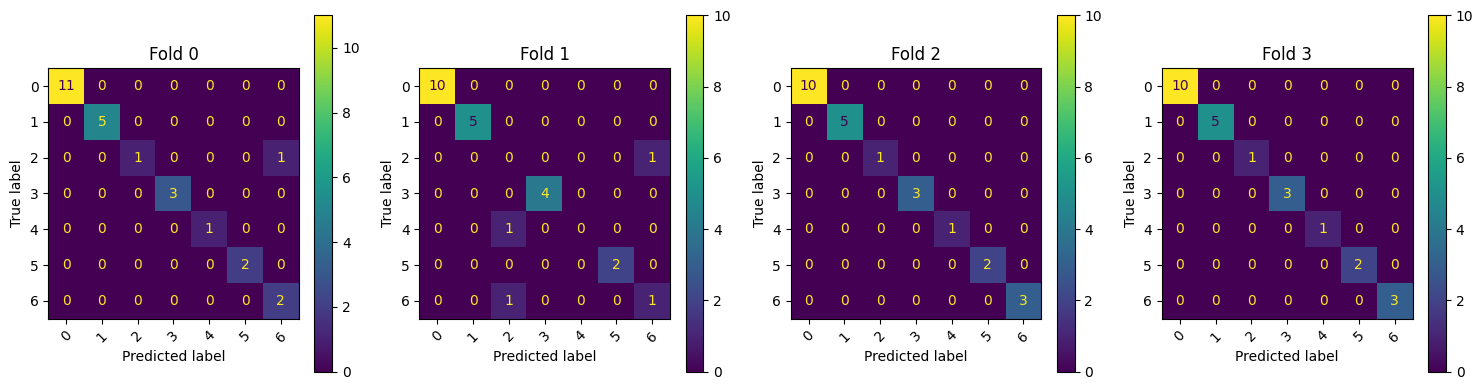

In [12]:
model = DecisionTreeClassifier(random_state=77)

print(f"Decision tree with {NUM_FOLD}-fold cross-validation\n")
skf = StratifiedKFold(n_splits=NUM_FOLD, shuffle=True, random_state=77)

fold_accuracy = []
tree_stats: list[dict[str, float]] = []

fig, ax = plt.subplots(1, NUM_FOLD, figsize=(15, 4))
for i, (train_index, test_index) in enumerate(skf.split(X_oh_np, y_np)):
    model.fit(X_oh_np[train_index], y_np[train_index])

    y_pred = model.predict(X_oh_np[test_index])

    acc = accuracy_score(y_np[test_index], y_pred)
    fold_accuracy.append(acc)

    max_depth = model.get_depth()
    avg_depth = average_tree_depth(model.tree_)
    n_branches = count_branches(model.tree_)

    tree_stats.append(
        {
            "max_depth": max_depth,
            "avg_depth": avg_depth,
            "n_branches": n_branches,
        }
    )

    print(classification_report(y_np[test_index], y_pred))

    # Plot confusion matrix
    cm = confusion_matrix(y_np[test_index], y_pred)
    disp = ConfusionMatrixDisplay(
        confusion_matrix=cm, display_labels=model.classes_
    )
    disp.plot(ax=ax[i], xticks_rotation=45)
    ax[i].set_title(f"Fold {i}")

print("\nCross-Validation Results:")
print(f"Mean Accuracy: {get_fold_print_string(fold_accuracy)}")

print(f"\nTree stats:")
print(
    f"Avg Max Depth: {get_fold_print_string([x['max_depth'] for x in tree_stats])}"
)
print(
    f"Avg Avg Depth: {get_fold_print_string([x['avg_depth'] for x in tree_stats])}"
)
print(
    f"Avg Branches: {get_fold_print_string([x['n_branches'] for x in tree_stats])}"
)

plt.tight_layout()

[Text(0.7777777777777778, 0.9285714285714286, 'milk=1 <= 0.5\ngini = 0.758\nsamples = 76\nvalue = [31, 15, 4, 10, 3, 6, 7]'),
 Text(0.6666666666666666, 0.7857142857142857, 'legs=2 <= 0.5\ngini = 0.785\nsamples = 45\nvalue = [0, 15, 4, 10, 3, 6, 7]'),
 Text(0.7222222222222222, 0.8571428571428572, 'True  '),
 Text(0.5555555555555556, 0.6428571428571429, 'fins=1 <= 0.5\ngini = 0.767\nsamples = 30\nvalue = [0, 0, 4, 10, 3, 6, 7]'),
 Text(0.4444444444444444, 0.5, 'backbone=1 <= 0.5\ngini = 0.725\nsamples = 20\nvalue = [0, 0, 4, 0, 3, 6, 7]'),
 Text(0.2222222222222222, 0.35714285714285715, 'legs=6 <= 0.5\ngini = 0.497\nsamples = 13\nvalue = [0, 0, 0, 0, 0, 6, 7]'),
 Text(0.1111111111111111, 0.21428571428571427, 'gini = 0.0\nsamples = 6\nvalue = [0, 0, 0, 0, 0, 0, 6]'),
 Text(0.3333333333333333, 0.21428571428571427, 'aquatic=1 <= 0.5\ngini = 0.245\nsamples = 7\nvalue = [0, 0, 0, 0, 0, 6, 1]'),
 Text(0.2222222222222222, 0.07142857142857142, 'gini = 0.0\nsamples = 6\nvalue = [0, 0, 0, 0, 0, 6, 

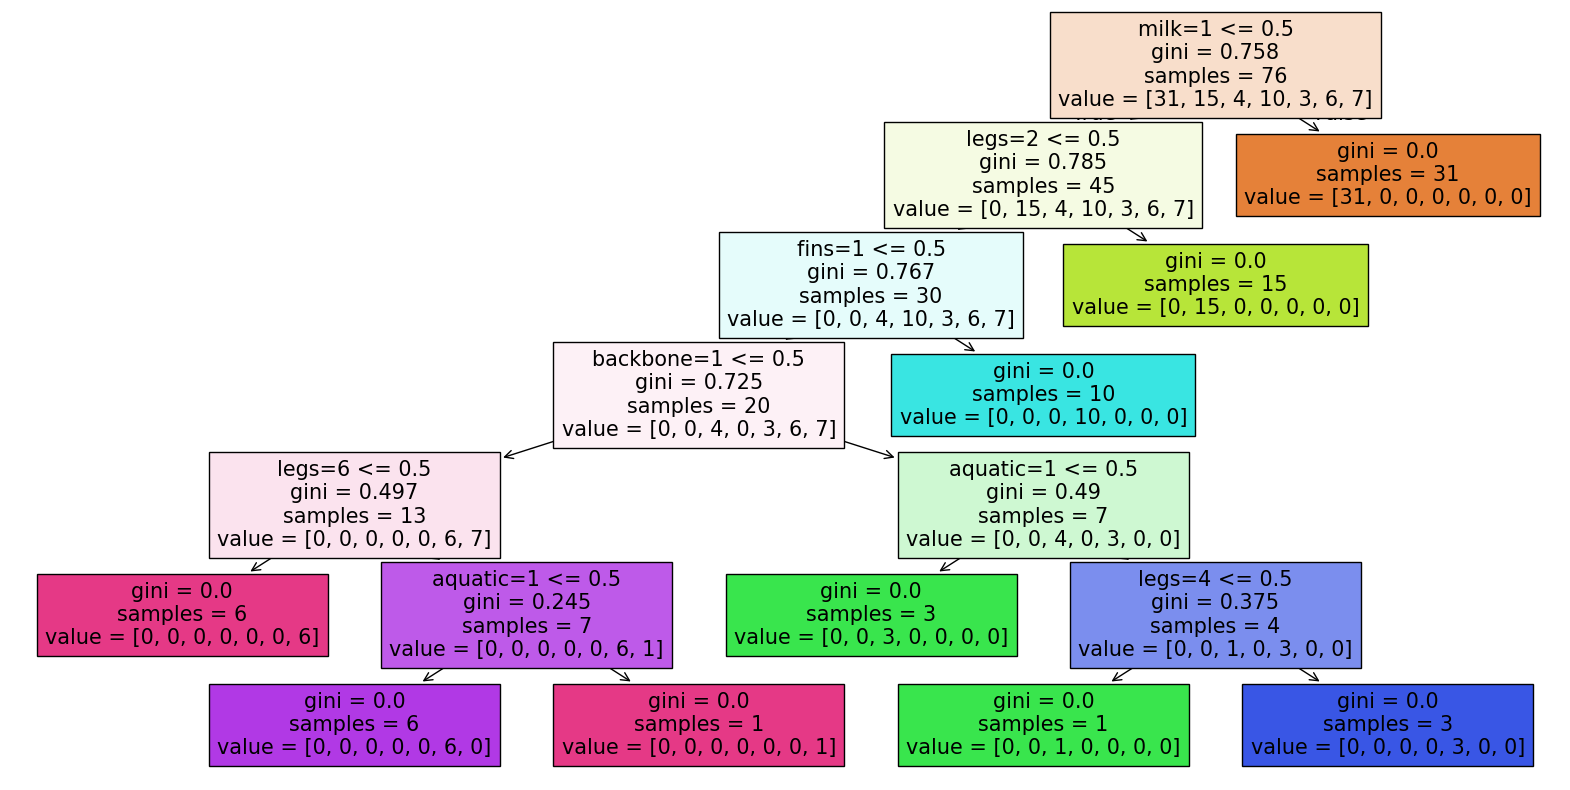

In [13]:
# display the decision tree
from sklearn.tree import plot_tree

plt.figure(figsize=(20, 10))
plot_tree(model, filled=True, feature_names=feature_names)